In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
import odor_stat_calculations as osc

import pandas as pd
import numpy as np

import scipy
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from joblib import load, dump

### Manual Training

In [3]:
def linear_decay(distance, max_distance=2):
    return max(0, (max_distance - distance) / max_distance)

def apply_boxcox(data):
    data_min = np.min(data)
    shift = 0 
    if data_min <= 0:
        shift = np.abs(data_min) + 0.5
        data_shifted = data + shift
    else:
        data_shifted = data

    transformed_data, lambda_ = scipy.stats.boxcox(data_shifted)

    return transformed_data, lambda_, shift

def get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2):
    weights_sum = 0
    weighted_sum = 0
    for dx in range(-max_distance, max_distance + 1):
        for dy in range(-max_distance, max_distance + 1):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, _ = grid_stats[(neighbor_x, neighbor_y)]
                weights_sum += weight
                weighted_sum += weight * neighbor_mean
    if weights_sum > 0:
        return weighted_sum / weights_sum
    else:
        return np.nan  
    

def get_combined_std(means, stds, weights):    
    
    variances = [std**2 for std in stds]
    weighted_variances_sum = np.average(variances, weights=weights)
        
    combined_std = np.sqrt(weighted_variances_sum)
    
    return combined_std


def get_weighted_stats(x_bin, y_bin, grid_stats, max_distance=2):
    mean_weights_sum = 0
    variance_weights_sum = 0
    weighted_mean_sum = 0
    weighted_variance_sum = 0
    means = []
    stds = []
    weights = []

    for dx in range(-max_distance, max_distance + 1):
        for dy in range(-max_distance, max_distance + 1):
            neighbor_x, neighbor_y = x_bin + dx, y_bin + dy
            if (neighbor_x, neighbor_y) in grid_stats:
                distance = np.sqrt(dx**2 + dy**2)
                weight = linear_decay(distance, max_distance)
                neighbor_mean, neighbor_std = grid_stats[(neighbor_x, neighbor_y)]

                # Collecting weighted statistics
                weighted_mean_sum += weight * neighbor_mean
                weighted_variance_sum += weight * (neighbor_std ** 2)  # Weighted sum of variances
                mean_weights_sum += weight
                variance_weights_sum += weight 

                means.append(neighbor_mean)
                stds.append(neighbor_std)
                weights.append(weight)

    if mean_weights_sum > 0:
        weighted_mean = weighted_mean_sum / mean_weights_sum
        # Compute combined standard deviation
        weighted_std = get_combined_std(means, stds, weights)
        return weighted_mean, weighted_std
    else:
        return np.nan, np.nan  



In [80]:
h5_files = [file for file in os.listdir(folder_path) if file.endswith('.h5')]

df_list = []

for file_name in h5_files:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_hdf(file_path)
    df_list.append(df)

concatenated_df = pd.concat(df_list, ignore_index=True)

query = 'odor>0'
test_df =concatenated_df.query(query)
test_df=test_df.reset_index(drop=True)

In [4]:
test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
df = pd.read_hdf(test_file_path)
query = 'odor>0'
test_df =df.query(query)
test_df=test_df.reset_index(drop=True)

In [7]:
n_bins_x = 100  # Number of bins along the x-axis
n_bins_y = 100  # Number of bins along the y-axis

# Define bin edges for x and y
x_bin_edges = np.linspace(test_df['distance_along_streakline'].min(), test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(test_df['nearest_from_streakline'].min(), test_df['nearest_from_streakline'].max(), n_bins_y + 1)

# Assign data points to bins using pd.cut, ensuring the rightmost edge is included
test_df['x_bin'] = pd.cut(test_df['distance_along_streakline'], bins=x_bin_edges, labels=False, include_lowest=True, right=True)
test_df['y_bin'] = pd.cut(test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False, include_lowest=True, right=True)

# Now check for rows without assigned bins
print("Rows without x_bin assigned:", test_df['x_bin'].isnull().sum())
print("Rows without y_bin assigned:", test_df['y_bin'].isnull().sum())


grid_stats = {}

test_df['odor_transformed'], lambda_ , shift = apply_boxcox(test_df.odor)

for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = test_df[(test_df['x_bin'] == i) & (test_df['y_bin'] == j)]['odor_transformed']
        if not grid_data.empty:
            grid_mean = grid_data.mean()
            grid_std = grid_data.std()
            grid_stats[(i, j)] = (grid_mean, grid_std)

Rows without x_bin assigned: 0
Rows without y_bin assigned: 0


In [7]:
# # test_file_path = "/home/gorilla/An/data/Sept13Plumes/plume1/train/diag17.h5"
# # test_df = pd.read_hdf(test_file_path)
# n_bins_x = 100  # for example, increasing from 4 to 10
# n_bins_y = 100

# x_bin_edges = np.linspace(test_df['distance_along_streakline'].min(), test_df['distance_along_streakline'].max(), n_bins_x + 1)
# y_bin_edges = np.linspace(test_df['nearest_from_streakline'].min(), test_df['nearest_from_streakline'].max(), n_bins_y + 1)

# print("Rows without x_bin assigned:", test_df['x_bin'].isnull().sum())
# print("Rows without y_bin assigned:", test_df['y_bin'].isnull().sum())

# test_df['x_bin'] = pd.cut(test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
# test_df['y_bin'] = pd.cut(test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

# # After assigning bins, check if any rows don't have a bin assigned


# # Dictionary to store the statistics for each grid
# grid_stats = {}

# test_df['odor_transformed'], lambda_ , shift = apply_boxcox(test_df.odor)

# for i in range(n_bins_x):
#     for j in range(n_bins_y):
#         grid_data = test_df[(test_df['x_bin'] == i) & (test_df['y_bin'] == j)]['odor_transformed']
#         if not grid_data.empty:
#             # Calculate mean and standard deviation for the grid
#             grid_mean = grid_data.mean()
#             grid_std = grid_data.std()
#             grid_stats[(i, j)] = (grid_mean, grid_std)

In [18]:
df_ = pd.read_hdf("/home/gorilla/An/data/Sept13Plumes/plume1/diag1.h5")  # Make sure to define `new_test_file_path`

query = 'odor>0'
new_test_df =df_.query(query)
new_test_df=new_test_df.reset_index(drop=True)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

predictions = []

# Loop through the test dataframe
for index, row in new_test_df.iterrows():
    x_bin, y_bin = row['x_bin'], row['y_bin']  # Get the bin coordinates for the row
    mean = get_weighted_average(x_bin, y_bin, grid_stats, max_distance=2)  # Use your chosen max_distance
    predictions.append(mean)

predictions = np.array(predictions)
y_true = (new_test_df['odor'].values) 

valid_indices = ~np.isnan(predictions)
y_pred = predictions[valid_indices]
y_true_valid = y_true[valid_indices]

In [19]:
if shift != 0:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_) - shift
else:
    predictions_original = scipy.special.inv_boxcox(predictions, lambda_)


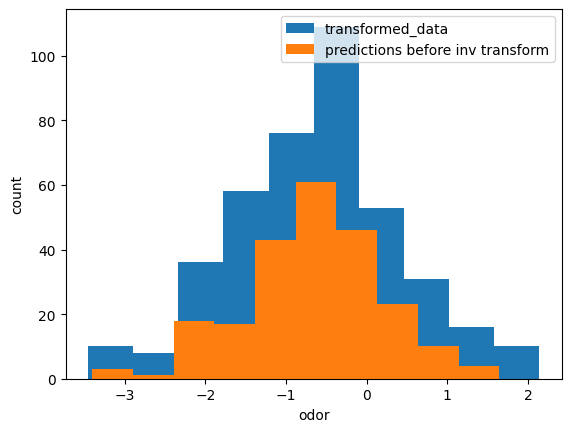

In [21]:
# plt.hist(test_df.odor, label = 'actual data')
plt.hist(test_df.odor_transformed, label = 'transformed_data')
plt.hist(predictions, label='predictions before inv transform')
# plt.hist(predictions_original, histtype='step', label='predictions after inv transform')

plt.xlabel('odor')
plt.ylabel('count')
plt.legend()


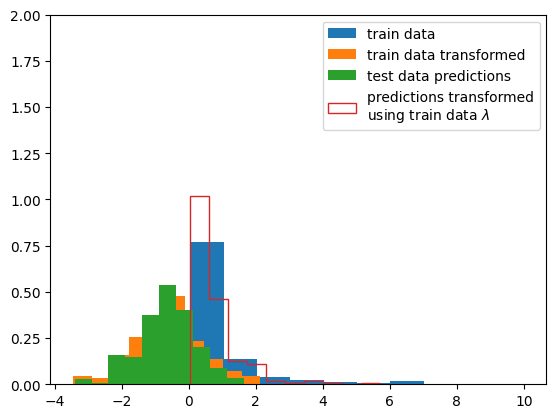

In [26]:
plt.hist(test_df.odor, bins=10, label = 'train data',density = True)
plt.hist(test_df.odor_transformed, label = 'train data transformed',density=True)
plt.hist(predictions, label='test data predictions', density=True)
plt.hist(predictions_original,bins=10,  histtype='step', label='predictions transformed\nusing train data $\lambda$', density=True)
plt.ylim(0,2)

plt.legend()

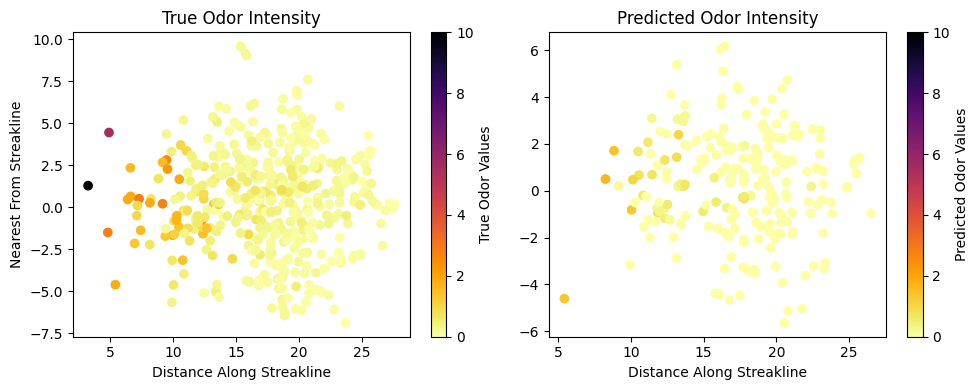

In [25]:
# Replace NaN predictions with zeros (or another value)
predictions_filled = np.nan_to_num(predictions_original, nan=0)  # Replace NaNs with 0

# There's no need to filter out NaN values since you've replaced them
x_pred_filled = new_test_df['distance_along_streakline'].values
y_pred_filled = new_test_df['nearest_from_streakline'].values

y_true_filled = np.nan_to_num(y_true, nan=0)  # Replace NaNs with 0, if applicable

# Now plot using the filled arrays
f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values
sc1 = axes[0].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=new_test_df.odor, 
                      cmap='inferno_r', vmin=0, vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values
sc2 = axes[1].scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], 
                      c=predictions, 
                      cmap='inferno_r', vmin=0, vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()


In [55]:
# plt.plot(new_test_df.odor,'o', markersize=5, label='true values')
# plt.plot(predictions_original , 'o' ,markersize=3, label='predicted values', c='black', alpha=0.5)
# # plt.xlabel('odor')
# plt.legend()

In [56]:
new_test_df['predictions_filled']=predictions_original

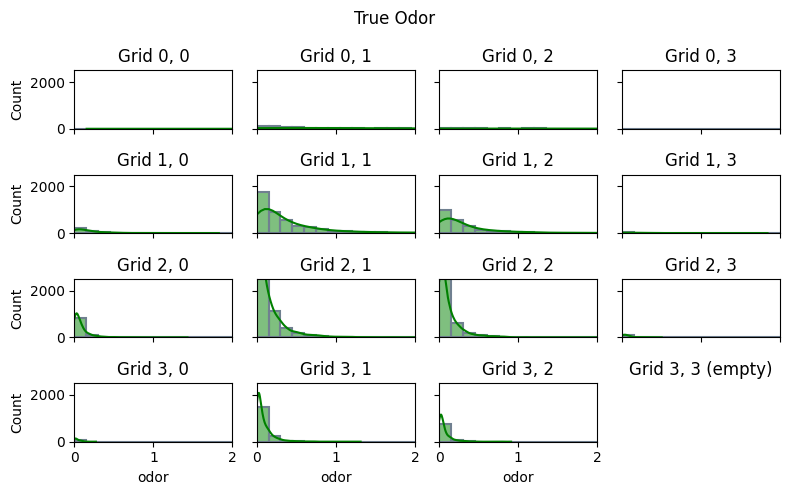

In [66]:
n_bins_x = 4
n_bins_y = 4
n_bins_hist = 20  

x_bin_edges = np.linspace(test_df['distance_along_streakline'].min(), test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(test_df['nearest_from_streakline'].min(), test_df['nearest_from_streakline'].max(), n_bins_y + 1)
test_df['x_bin'] = pd.cut(test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
test_df['y_bin'] = pd.cut(test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

# Determine global range for histogram bins
global_min = test_df['odor'].min()
global_max = test_df['odor'].max()
bin_edges = np.linspace(0, 3, n_bins_hist + 1)

# Define specific x-axis limits
specific_x_min = 0  
specific_x_max = 2 

fig, axes = plt.subplots(n_bins_x, n_bins_y, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = test_df[(test_df['x_bin'] == i) & (test_df['y_bin'] == j)]['odor']
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=axes[i, j], color='green', edgecolor='slategray', linewidth=1.5)
            axes[i, j].set_xlim([specific_x_min, specific_x_max])
            axes[i, j].set_ylim([0, 2500])
            axes[i, j].set_title(f'Grid {i}, {j}')
        else:
            axes[i, j].set_title(f'Grid {i}, {j} (empty)')
            axes[i, j].axis('off')

fig.suptitle('True Odor')
fig.tight_layout()

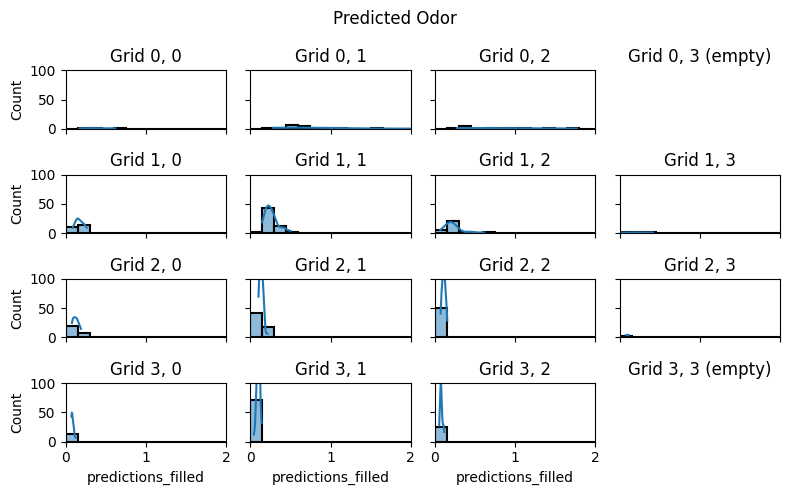

In [65]:
n_bins_x = 4
n_bins_y = 4
n_bins_hist = 20  # Number of bins for the histograms

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)

# global_min = new_test_df['predictions_filled'].min()
# global_max = new_test_df['predictions_filled'].max()
bin_edges = np.linspace(0, 3, n_bins_hist + 1)

specific_x_min = 0  
specific_x_max = 2 

fig, axes = plt.subplots(n_bins_x, n_bins_y, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predictions_filled']
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=axes[i, j], linewidth=1.5)
            axes[i, j].set_xlim([specific_x_min, specific_x_max])
            axes[i, j].set_ylim([0, 100]) 
            axes[i, j].set_title(f'Grid {i}, {j}')
        else:
            axes[i, j].set_title(f'Grid {i}, {j} (empty)')
            axes[i, j].axis('off')

fig.suptitle('Predicted Odor')
fig.tight_layout()

In [98]:
from scipy.stats import ks_2samp
import numpy as np

# Initialize an array to store KS test results
ks_statistics = np.empty((n_bins_x, n_bins_y))
ks_pvalues = np.empty((n_bins_x, n_bins_y))

# Iterate over each grid cell
for i in range(n_bins_x):
    for j in range(n_bins_y):
        # Extract true and predicted odor values for the current grid cell
        true_values = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        predicted_values = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predictions_filled']
        
        # Perform KS test if both true and predicted values are available
        if not true_values.empty and not predicted_values.empty:
            ks_stat, ks_pvalue = ks_2samp(true_values, predicted_values)
            ks_statistics[i, j] = ks_stat
            ks_pvalues[i, j] = ks_pvalue
        else:
            ks_statistics[i, j] = np.nan  # Mark as NaN if data is missingpredictions_filled
            ks_pvalues[i, j] = np.nan


/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


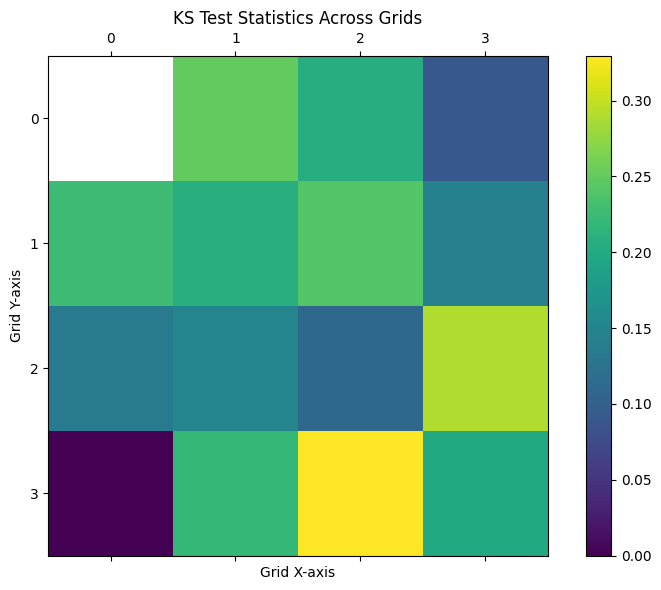

In [99]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(ks_statistics, interpolation='nearest', cmap='viridis')  # Use 'viridis' or another colormap
fig.colorbar(cax)
ax.set_title('KS Test Statistics Across Grids')
ax.set_xlabel('Grid X-axis')
ax.set_ylabel('Grid Y-axis')
fig.tight_layout()
predictions_filled

In [100]:
# fig, ax = plt.subplots(figsize=(8, 6))
# cax = ax.matshow(ks_pvalues, interpolation='nearest', cmap='viridis')
# fig.colorbar(cax)
# ax.set_title('KS Test P-values Across Grids')
# ax.set_xlabel('Grid X-axis')
# ax.set_ylabel('Grid Y-axis')
# fig.tight_layout()


In [101]:
median_ks_statistic = np.nanmedian(ks_statistics)
print(f'Median KS Test Statistic: {median_ks_statistic}')

mean_ks_statistic = np.nanmean(ks_statistics)
print(f'Mean KS Test Statistic: {mean_ks_statistic}')


significance_level = 0.05
num_significant = np.sum(ks_pvalues < significance_level)
print(f'Number of significant grids (p < {significance_level}): {num_significant} out of {n_bins_x * n_bins_y}')


Median KS Test Statistic: 0.2054794520547945
Mean KS Test Statistic: 0.18634746749289555
Number of significant grids (p < 0.05): 5 out of 16


### Effect Size

In [105]:

def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)
    pooled_sd = np.sqrt(((n1 - 1) * sd1 ** 2 + (n2 - 1) * sd2 ** 2) / (n1 + n2 - 2))
    d = (mean1 - mean2) / pooled_sd
    return d

ks_results = {}
cohens_d_results = {}
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_true = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        grid_pred_mean = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['predictions_filled']
        
        if not grid_true.empty and not grid_pred_mean.empty:
            ks_statistic, p_value = ks_2samp(grid_true, grid_pred_mean)
            ks_results[(i, j)] = (round(ks_statistic,2), "{:.2e}".format(p_value))
            
            d = cohens_d(grid_true, grid_pred_mean)
            cohens_d_results[(i, j)] = "{:.2e}".format(d)
        else:
            ks_results[(i, j)] = ("nan", "nan")  
            cohens_d_results[(i, j)] = "nan"

for key in sorted(ks_results.keys()):
    print(f"Grid {key} - KS statistic: {ks_results[key][0]}, p-value: {ks_results[key][1]}")
    print(f"Grid {key} - Cohen's d: {cohens_d_results[key]}")


Grid (0, 0) - KS statistic: nan, p-value: nan
Grid (0, 0) - Cohen's d: nan
Grid (0, 1) - KS statistic: 0.25, p-value: 7.73e-02
Grid (0, 1) - Cohen's d: 1.20e-01
Grid (0, 2) - KS statistic: 0.21, p-value: 9.17e-02
Grid (0, 2) - Cohen's d: 3.54e-01
Grid (0, 3) - KS statistic: 0.09, p-value: 1.00e+00
Grid (0, 3) - Cohen's d: 4.26e-01
Grid (1, 0) - KS statistic: 0.23, p-value: 4.14e-01
Grid (1, 0) - Cohen's d: 7.51e-01
Grid (1, 1) - KS statistic: 0.21, p-value: 1.44e-03
Grid (1, 1) - Cohen's d: -1.68e-01
Grid (1, 2) - KS statistic: 0.24, p-value: 2.22e-05
Grid (1, 2) - Cohen's d: -1.94e-01
Grid (1, 3) - KS statistic: 0.14, p-value: 5.45e-01
Grid (1, 3) - Cohen's d: -1.78e-01
Grid (2, 0) - KS statistic: 0.13, p-value: 5.85e-01
Grid (2, 0) - Cohen's d: 5.53e-01
Grid (2, 1) - KS statistic: 0.15, p-value: 2.61e-02
Grid (2, 1) - Cohen's d: -2.79e-01
Grid (2, 2) - KS statistic: 0.11, p-value: 1.15e-01
Grid (2, 2) - Cohen's d: -2.73e-01
Grid (2, 3) - KS statistic: 0.29, p-value: 1.04e-02
Grid (2,

/tmp/ipykernel_2026434/1582298032.py:6: RuntimeWarning: invalid value encountered in scalar divide
  d = (mean1 - mean2) / pooled_sd
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [104]:
new_test_df.keys()

Index(['distance_along_streakline', 'nearest_from_streakline', 'odor', 'x_bin',
       'y_bin', 'predictions_filled'],
      dtype='object')